<a href="" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<img src="./src/copernicus-logo.png"><span style="margin-left: 40px"></span><img src="./src/cds-logo.jpeg">

# Data Modelling

During this phase, we will discuss about possibles models to predict discharge given a temperature and past history of a particular river location according to the result of the Granger Causality.

## Choice of the Model

A wide array of methods are available for time series forecasting. One of the most commonly used is Autoregressive Moving Average (ARMA), a statistical model that predicts future values using past values. However, this method is flawed because it does not capture seasonal trends. It also assumes that the time series data is stationary, meaning that its statistical properties would not change over time. However, this type of behavior is an idealized assumption that does not hold in practice, which means ARMA may provide skewed results. Our ADF and KPSS tests give the applicability of this type; they defined that air temperature is stationary. However, the discharge does not follow the same property. An extension of ARMA is the Autoregressive Integrated Moving Average (ARIMA) model, which does not assume stationarity but still that the data exhibits little to no seasonality. Fortunately, the seasonal ARIMA (SARIMA) variant is a statistical model that can work with non-stationary data and capture some seasonality; so we can build a model following this pattern to implement an initial threshold, and we will carry out other considerations and other algorithms to improves experimental model and find out the best approach.


## Libraries dependencies

In [2]:
%pip install seaborn
%pip instal matplotlib
%pip install sklearn
%pip install pandas
#!pip install seaborn

You should consider upgrading via the '/usr/local/opt/python@3.9/bin/python3.9 -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.
ERROR: unknown command "instal" - maybe you meant "install"
Note: you may need to restart the kernel to use updated packages.
You should consider upgrading via the '/usr/local/opt/python@3.9/bin/python3.9 -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.
You should consider upgrading via the '/usr/local/opt/python@3.9/bin/python3.9 -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


In [1]:
import datetime, json
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.formula.api as smf
import statsmodels.tsa.api as smt
import statsmodels.api as sm
import scipy.stats as scs
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [3]:
j = 6
df = pd.DataFrame(columns=['time', 'lat', 'lon', 'discharge', 'temp', 'prec'])
for i in range(2011, 2022):
    tmp = pd.read_csv("samples/italy-dtp-{}-{}.csv".format(i,j), usecols=['time', 'lat', 'lon', 'discharge', 'temp', 'prec'])
    df = pd.concat([df, tmp])
    j += 1

In [4]:
df.head()

,time,lat,lon,discharge,temp,prec
0,2011-01-01 12:00:00,44.750378,7.56052,11.211914,5.205774,0.0
1,2011-01-02 12:00:00,44.750378,7.56052,10.950195,4.364069,0.000006
2,2011-01-03 12:00:00,44.750378,7.56052,10.685547,6.473016,0.000002
3,2011-01-04 12:00:00,44.750378,7.56052,10.419922,8.097437,0.0
4,2011-01-05 12:00:00,44.750378,7.56052,10.15918,6.304498,0.0


In [5]:
df.describe()

,time,lat,lon,discharge,temp,prec
count,35788326,3.578833e+07,3.578833e+07,3.578833e+07,3.578833e+07,35788326.0
unique,4018,8.899000e+03,8.905000e+03,9.418870e+05,1.560222e+06,29903592.0
top,2011-01-01 12:00:00,4.666971e+01,9.002067e+00,9.765625e-04,1.226299e+01,0.0
freq,8907,8.036000e+03,8.036000e+03,6.753800e+04,7.600000e+01,3911611.0


From the Granger Causality, we found that precipitations don't generate causal dependency on the discharge, so we can avoid to consider this column on our model development.

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 35788326 entries, 0 to 3251054
Data columns (total 6 columns):
 #   Column     Dtype 
---  ------     ----- 
 0   time       object
 1   lat        object
 2   lon        object
 3   discharge  object
 4   temp       object
 5   prec       object
dtypes: object(6)
memory usage: 1.9+ GB


This notebook have the scope to test learning algorithms and find the best one for the data forecasting. So, we can start from a sample point and analyze its time series.

In [7]:
df = df[df['lat'] == 41.23425]
df = df[df['lon'] == 13.701608]
df.head()

,time,lat,lon,discharge,temp,prec
3250690,2011-01-01 12:00:00,41.23425,13.701608,0.399414,13.251428,0.00001
3250691,2011-01-02 12:00:00,41.23425,13.701608,0.352539,14.996301,0.000125
3250692,2011-01-03 12:00:00,41.23425,13.701608,0.311523,12.333337,0.000086
3250693,2011-01-04 12:00:00,41.23425,13.701608,0.275391,15.162592,0.000006
3250694,2011-01-05 12:00:00,41.23425,13.701608,0.311523,12.16366,0.000004


In [8]:
original_df = df
df.index = pd.to_datetime(df['time'], format = '%Y-%m-%d %H:%M:%S')
df = df.drop(columns=['time'])

Text(0, 0.5, 'Discharge (m^3/s)')

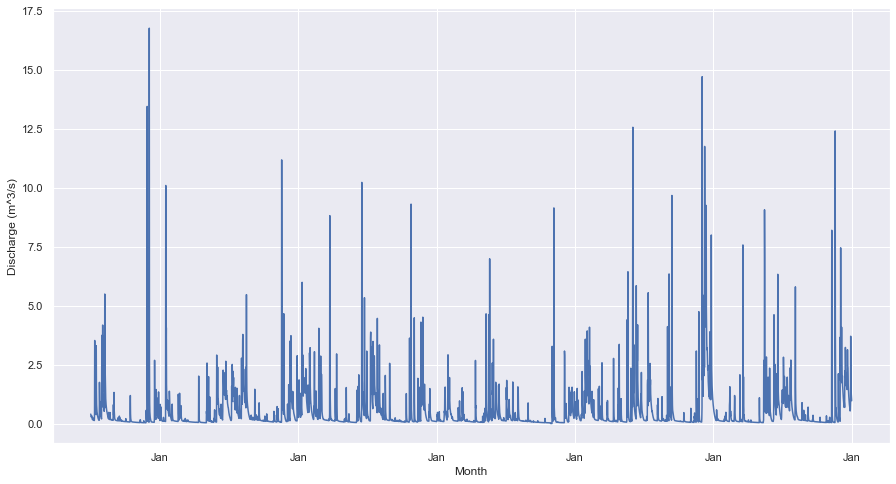

In [14]:
sns.set(rc={'figure.figsize':(15, 8)})
ax = sns.lineplot(x='time', y='discharge', data=df, markers='')
import matplotlib.dates as mdates
myFmt = mdates.DateFormatter('%b')
ax.get_xaxis().set_major_formatter(myFmt)
ax.set_xlabel('Month')
ax.set_ylabel('Discharge (m^3/s)')

We can observe a possible seasonality on  the discharge values over time. Our hypothesis is based on the temperature changing due to the seasons related also to some weather events like ice melting. We will try to use some time series forecasting algorithm like SARIMA to find a method of prediction related to discharge from its own history.

In [15]:
train = df.loc[df.index < pd.to_datetime('2019-01-01 00:00:00')]
test = df.loc[(df.index >= pd.to_datetime('2019-01-01 00:00:00'))]

In [16]:
# we remove also prec because it failed the granger causality
train = train.drop(columns=['lat', 'lon', 'prec']) 
test = test.drop(columns=['lat', 'lon', 'prec'])

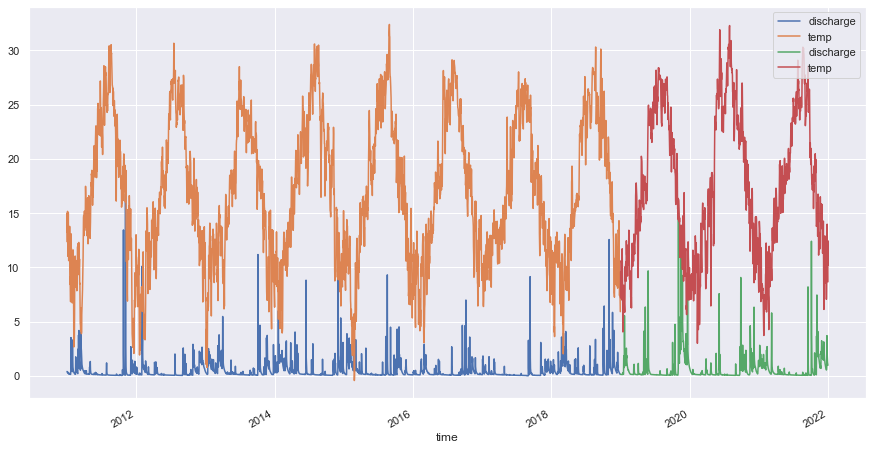

In [17]:
fig, ax = plt.subplots()
train.plot(ax=ax, label='train')
test.plot(ax=ax, label='test')
plt.legend()
plt.show()

## SARIMA Modelling

In [26]:
original_df.head()

,time,lat,lon,discharge,temp,prec
time,,,,,,
2011-01-01 12:00:00,2011-01-01 12:00:00,41.23425,13.701608,0.399414,13.251428,0.00001
2011-01-02 12:00:00,2011-01-02 12:00:00,41.23425,13.701608,0.352539,14.996301,0.000125
2011-01-03 12:00:00,2011-01-03 12:00:00,41.23425,13.701608,0.311523,12.333337,0.000086
2011-01-04 12:00:00,2011-01-04 12:00:00,41.23425,13.701608,0.275391,15.162592,0.000006
2011-01-05 12:00:00,2011-01-05 12:00:00,41.23425,13.701608,0.311523,12.16366,0.000004


In [27]:
rawData = original_df.copy(deep=True)
rawData['discharge'] = rawData['discharge'].astype(float)
rawData['time'] = pd.to_datetime(rawData['time'], format = '%Y-%m-%d %H:%M:%S')

In [28]:
rawData.index = rawData.time
rawData.drop(columns=['temp','prec','lat','lon'], inplace=True)
rawData.head()

,time,discharge
time,,
2011-01-01 12:00:00,2011-01-01 12:00:00,0.399414
2011-01-02 12:00:00,2011-01-02 12:00:00,0.352539
2011-01-03 12:00:00,2011-01-03 12:00:00,0.311523
2011-01-04 12:00:00,2011-01-04 12:00:00,0.275391
2011-01-05 12:00:00,2011-01-05 12:00:00,0.311523


In [29]:
rawData = rawData.dropna()
rawData = rawData.drop(columns=['time'])

In [30]:
# training and validation splitting 
train = rawData[:int(0.8*(len(rawData)))]
valid = rawData[int(0.8*(len(rawData))):]

In [31]:
train.head()

,discharge
time,
2011-01-01 12:00:00,0.399414
2011-01-02 12:00:00,0.352539
2011-01-03 12:00:00,0.311523
2011-01-04 12:00:00,0.275391
2011-01-05 12:00:00,0.311523


In [32]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
### Crashed again upon completion, make sure the time series is ok -> computation moved to Colab

# Create a SARIMAX model
model = SARIMAX(train['discharge'], order=(4,1,1), seasonal_order=(0,1,1,24))
# p - try 0, 1, 2, 3, 4;

/usr/local/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


In [33]:
# Fit the model
results = model.fit()

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.42506D+00    |proj g|=  3.48410D-01


 This problem is unconstrained.



At iterate    5    f=  1.30020D+00    |proj g|=  1.23172D-01

At iterate   10    f=  1.26929D+00    |proj g|=  1.81328D-02

At iterate   15    f=  1.26448D+00    |proj g|=  2.76634D-03

At iterate   20    f=  1.26446D+00    |proj g|=  6.95786D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     20     24      1     0     0   6.958D-06   1.264D+00
  F =   1.2644592313137879     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            


In [34]:
print(results.summary())

                                     SARIMAX Results                                      
Dep. Variable:                          discharge   No. Observations:                 3214
Model:             SARIMAX(4, 1, 1)x(0, 1, 1, 24)   Log Likelihood               -4063.972
Date:                            Tue, 14 Jun 2022   AIC                           8141.944
Time:                                    16:38:30   BIC                           8184.416
Sample:                                01-01-2011   HQIC                          8157.174
                                     - 10-19-2019                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.3292      0.009     36.672      0.000       0.312       0.347
ar.L2          0.0340      0.016   

## Forecasting Testing for SARIMA 

We will try to test SARIMA on the best model and observe results related to model fitting. We will display forecast results on weekly and mean predictions.

In [35]:
# Generate predictions
one_step_forecast = results.get_prediction(start=-48)

# Extract prediction mean
mean_forecast = one_step_forecast.predicted_mean

# Get confidence intervals of predictions
confidence_intervals = one_step_forecast.conf_int()

# Select lower and upper confidence limits
lower_limits = confidence_intervals.loc[:, 'lower discharge']
upper_limits = confidence_intervals.loc[:, 'upper discharge']

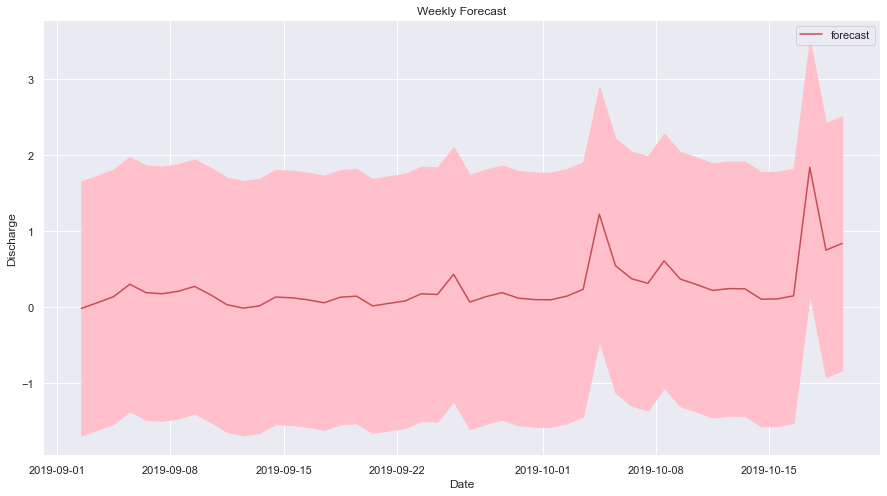

In [36]:
# plot the dranse data

# plot your mean predictions
plt.plot(mean_forecast.index, mean_forecast, color='r', label='forecast')

# shade the area between your confidence limits
plt.fill_between(lower_limits.index, lower_limits, 
               upper_limits, color='pink')

# set labels, legends and show plot
plt.xlabel('Date')
plt.ylabel('Discharge')
plt.title('Weekly Forecast')
plt.legend()
plt.show()

In [37]:
# Generate predictions
dynamic_forecast = results.get_prediction(start=-6, dynamic=True)

# Extract prediction mean
mean_forecast = dynamic_forecast.predicted_mean

# Get confidence intervals of predictions
confidence_intervals = dynamic_forecast.conf_int(alpha=0.32) # 95 percent confidence interval

# Select lower and upper confidence limits
lower_limits = confidence_intervals.loc[:,'lower discharge']
upper_limits = confidence_intervals.loc[:,'upper discharge']

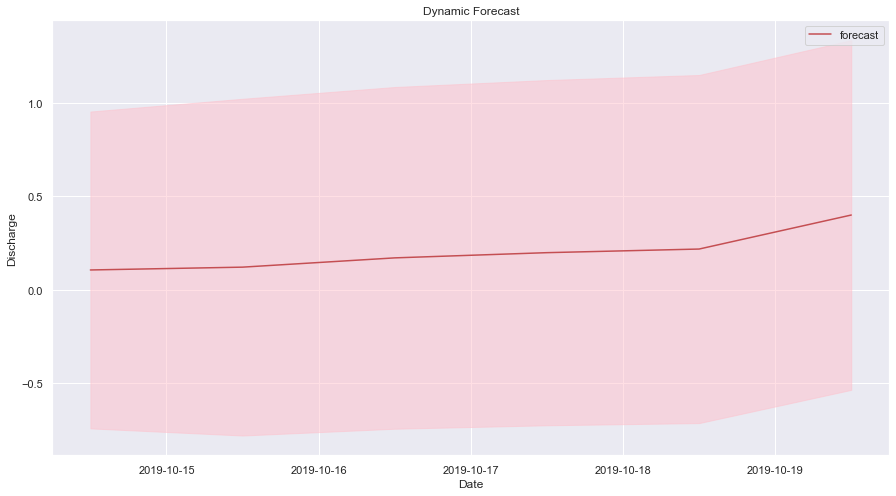

In [38]:
# plot your mean predictions
plt.plot(mean_forecast.index, mean_forecast, color='r', label='forecast')

# shade the area between your confidence limits
plt.fill_between(lower_limits.index, lower_limits, 
               upper_limits, color='pink', alpha=0.5)

# set labels, legends and show plot
plt.xlabel('Date')
plt.ylabel('Discharge')
plt.title('Dynamic Forecast')
plt.legend()

Text(0.5, 0, 'Time')

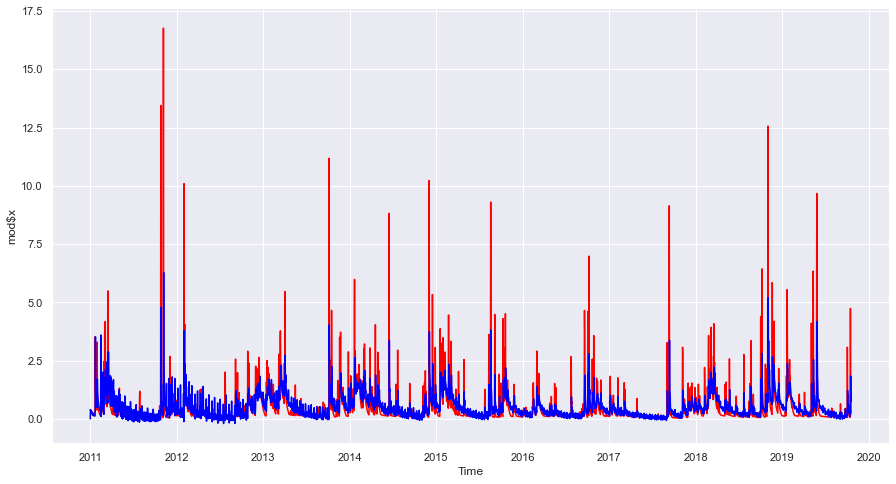

In [39]:
plt.plot(train, c='red')
plt.plot(results.fittedvalues, c='blue')
plt.ylabel("mod$x")
plt.xlabel("Time")

In [40]:
import math
from sklearn.metrics import mean_squared_error

rmse = math.sqrt(mean_squared_error(train, results.fittedvalues))
print(f"RMSE: {rmse}")

RMSE: 0.8679080516675083


Considering only the discharge history data, we can predict with almost good accuracy future data. SARIMA will determinate its values on the seasonality of the time series, this characterstics should be good for short-term prediction but worst for long-term.

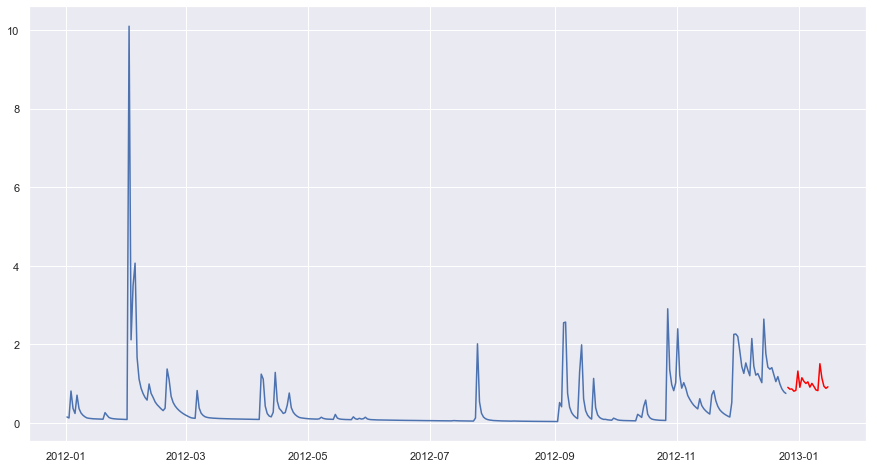

In [41]:
forecast = results.predict(start = 725, end = 745, dynamic= True) 
plt.plot(train[365:725])
plt.plot(forecast, c= "red")

In [42]:
print('Forecast: {}'.format(forecast))

Forecast: 2012-12-26 12:00:00    0.904485
2012-12-27 12:00:00    0.859371
2012-12-28 12:00:00    0.864596
2012-12-29 12:00:00    0.806876
2012-12-30 12:00:00    0.829491
2012-12-31 12:00:00    1.319596
2013-01-01 12:00:00    0.906378
2013-01-02 12:00:00    1.148910
2013-01-03 12:00:00    1.059160
2013-01-04 12:00:00    1.004383
2013-01-05 12:00:00    1.044973
2013-01-06 12:00:00    0.911215
2013-01-07 12:00:00    1.005838
2013-01-08 12:00:00    0.929923
2013-01-09 12:00:00    0.840137
2013-01-10 12:00:00    0.822086
2013-01-11 12:00:00    1.506328
2013-01-12 12:00:00    1.140042
2013-01-13 12:00:00    0.934991
2013-01-14 12:00:00    0.880678
2013-01-15 12:00:00    0.918298
Freq: D, Name: predicted_mean, dtype: float64


In [44]:
import pickle
pickle.dump(results, open('sarimax', 'wb'))

## Applying Temperature Dependencies on Multivariate Time Series (MTS) 

Granger Causality gives us the dependencies information about temperatures in causal relation with the discharge. In other words, we can say that the temperature can change the river discharge variability over time. This effect shows us a seasonality of the temperatures distribution on a single point related to its discharge value. A multivariate time series (MTS) has more than one time-dependent variable and each variable depends not onlyon its history but also has some dependency on other variables. During the Data Correlation, we used already a MTS method: VAR. It was used to determinate the best lang for the Granger Causality. However, we can also use it as a prediction model for future values of the discharge based on the equation in relation to its history and temperature past values.

In [61]:
df.head()

,discharge,temp,prec
time,,,
2011-01-01 12:00:00,0.399414,13.251428,0.00001
2011-01-02 12:00:00,0.352539,14.996301,0.000125
2011-01-03 12:00:00,0.311523,12.333337,0.000086
2011-01-04 12:00:00,0.275391,15.162592,0.000006
2011-01-05 12:00:00,0.311523,12.16366,0.000004


In [63]:
df = df.drop(columns=["lat", "lon", "prec"])

In [65]:
data = df.copy(deep=True)
data['discharge'] = data['discharge'].astype(float)
data['temp'] = data['temp'].astype(float)

In [66]:
train = df[:int(0.8*(len(df)))]
valid = df[int(0.8*(len(df))):]

In [67]:
print('Train Length {}'.format(len(train)))
print('Test Length {}'.format(len(test)))
train.head()

Train Length 3214
Test Length 1096


,discharge,temp
time,,
2011-01-01 12:00:00,0.399414,13.251428
2011-01-02 12:00:00,0.352539,14.996301
2011-01-03 12:00:00,0.311523,12.333337
2011-01-04 12:00:00,0.275391,15.162592
2011-01-05 12:00:00,0.311523,12.16366


In [73]:
train = np.asarray(train)

In [79]:
from statsmodels.tsa.vector_ar.var_model import VAR
model = VAR(endog=train.astype(float))
var_model = model.fit()
var_model.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Tue, 14, Jun, 2022
Time:                     16:58:38
--------------------------------------------------------------------
No. of Equations:         2.00000    BIC:                   0.454016
Nobs:                     3213.00    HQIC:                  0.446737
Log likelihood:          -9823.25    FPE:                    1.55686
AIC:                     0.442671    Det(Omega_mle):         1.55396
--------------------------------------------------------------------
Results for equation y1
           coefficient       std. error           t-stat            prob
------------------------------------------------------------------------
const         0.583683         0.044074           13.243           0.000
L1.y1         0.398305         0.016184           24.610           0.000
L1.y2        -0.017256         0.002303           -7.492           0.000

Results for equation 

In [ ]:
# make prediction on validation
ite = 1096
prediction = var_model.forecast(var_model.endog, steps = ite)

In [144]:
prediction

array([[ 0.40587696, 16.17366354],
       [ 0.46624787, 16.19427403],
       [ 0.48993827, 16.21461334],
       ...,
       [ 0.48145533, 17.03687188],
       [ 0.48145533, 17.03687188],
       [ 0.48145533, 17.03687188]])

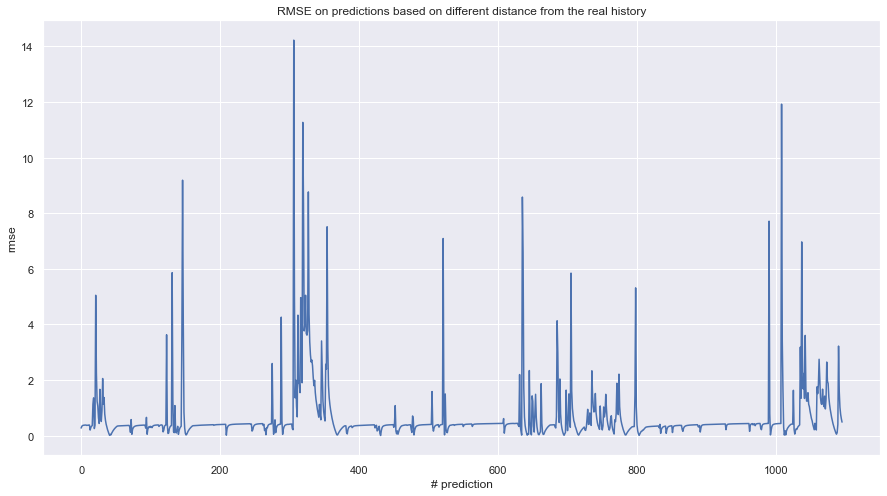

In [141]:
import math
from sklearn.metrics import mean_squared_error
rmse = []
for i in range(0, ite):
    rmse.append(math.sqrt(mean_squared_error([prediction[i][0]],[test['discharge'][i]])))


rmse = np.asarray(rmse)
index = np.asarray([i for i in range(0,ite)])
plt.plot(index, rmse)
plt.title('RMSE on predictions based on different distance from the real history')
plt.xlabel('# prediction')
plt.ylabel('rmse')
plt.show()